In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
plt.rcParams.update({'font.size': 18})

In [28]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\seasonal\clim'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\seasonal\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
seasons = ['DJF', 'MAM', 'JJA', 'SON']

In [3]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [21]:
vmin = 50
vmax = 400
cmap = mpl.cm.Blues
proj = ccrs.Mercator()
levels = 8
extend_cbar = 'both'
#####
bounds = np.linspace(vmin,vmax,levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
seasons = ['DJF', 'MAM', 'JJA', 'SON']
extend = [-81, -42, -20, 11]


C:\Users\luisg\AppData\Local\Temp\ipykernel_21208\3059424869.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


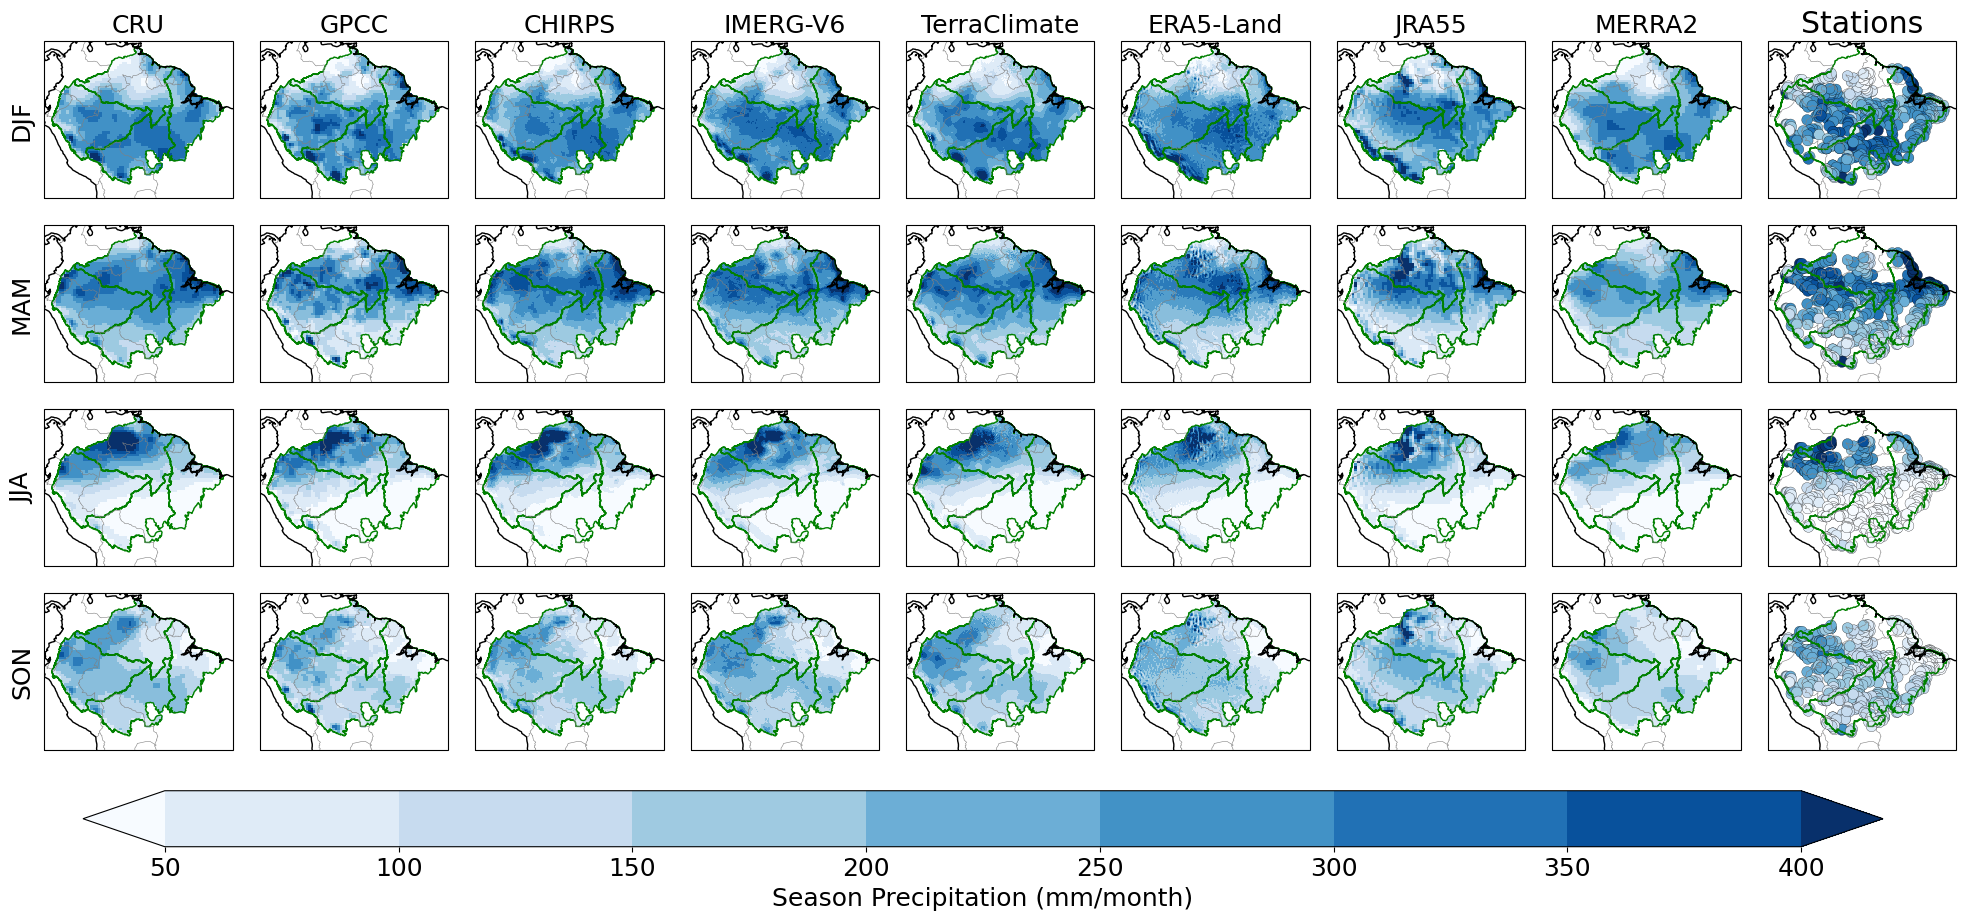

In [22]:
#plot each dataset and each season
fig, axes = plt.subplots(ncols=len(datasets)+1, nrows=4, figsize=(20, 8), subplot_kw={'projection': proj})
#create cax in the bottom of the figure
cax = fig.add_axes([0.05, -0.08, 0.9, 0.07])

fig.colorbar(sm, cax=cax, orientation='horizontal', label='Season Precipitation (mm/month)')

for axx in axes.flatten():
        axx.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        axx.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axx.set_extent([-81, -42, -20, 11])
        axx.coastlines()  
        # Add a title for each subplot
        #ax.set_title(datasets_names[i])
        # Remove x and y labels  
    

for i, name in enumerate(datasets_names):
    for j in range(4):
        ax = axes[j, i]
        ds = ds_dict[name]
        ds.sel(season=seasons[j]).pr.plot(ax= axes[j, i] , cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= levels)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        
          
        if i == 0:
            axes[j, i].set_ylabel(seasons[j], fontsize=18)
        if j == 0:
            axes[j, i].set_title(datasets_names[i], fontsize=18)
#plot the stations season metrics
for j in range(4):
    stations.to_crs(proj).plot(ax=axes[j, 8],column='clim_' + seasons[j], cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black', s=60)
  
  
    if j == 0:
        axes[j, 8].set_title('Stations')

plt.tight_layout()

# EDA

In [5]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().reset_index().drop(columns=['lat', 'lon'])
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['pr', 'Region', 'Dataset','season']].dropna().reset_index(drop=True)
#df = df.rename(columns={'mask':'region'})
df['Region'] = df['Region'].replace({ 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'})

C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\2933218030.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\2933218030.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\2933218030.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\2933218030.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\2933218030.py:6: FutureWarning: The frame.append method is dep

In [6]:
#in stations transform clim_season in column total and season
stations_season = stations.melt(id_vars=['Code', 'Region'], value_vars=['clim_DJF', 'clim_MAM', 'clim_JJA', 'clim_SON'], var_name='season', value_name='pr').dropna().reset_index(drop=True)
#in season just the last 3 letters
stations_season['season'] = stations_season['season'].str[-3:]
stations_season.drop(columns=['Code'], inplace=True)
stations_season['Dataset'] = 'Stations'
df = df.append(stations_season)

C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\522669857.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(stations_season)


In [29]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]

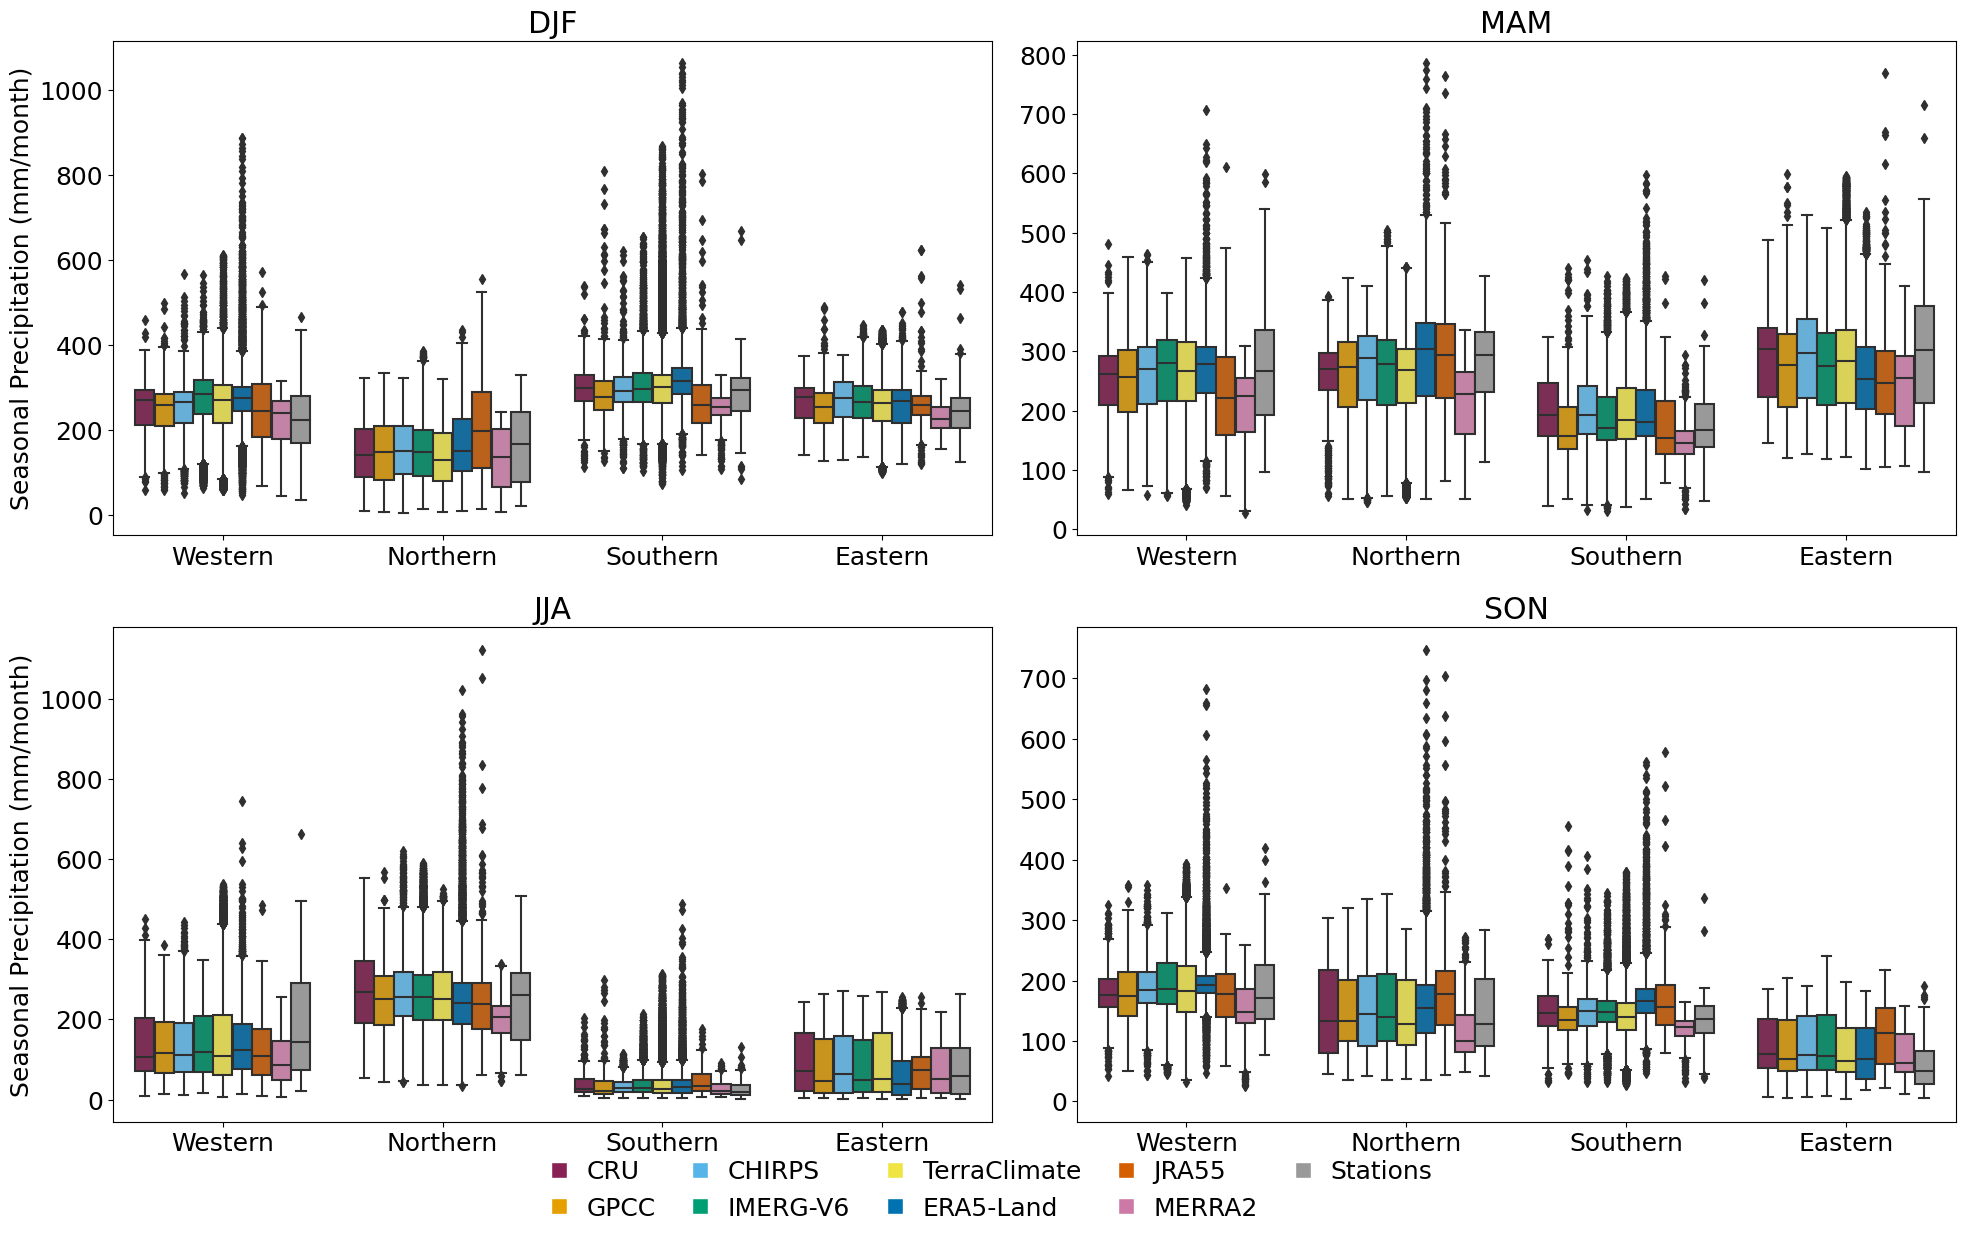

In [9]:
#plot box plot for each season
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))
axes = axes.flatten()
for i, season in enumerate(seasons):
    ax = axes[i]
    sns.boxplot(x="Region", y="pr", hue="Dataset", data=df[df['season']==season], ax=ax, hue_order=hue_order, palette=wong)
    ax.set_title(season)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend_.remove()
    # set label only in firstcolumn of plot
    if i%2==0:
        ax.set_ylabel('Seasonal Precipitation (mm/month)')
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)

plt.tight_layout()

# pixel


In [20]:
stations_season = stations.melt(id_vars=['Code', 'Region'], value_vars=['clim_DJF', 'clim_MAM', 'clim_JJA', 'clim_SON'], var_name='season', value_name='pr').dropna().reset_index(drop=True)
stations_season['season'] = stations_season['season'].str[-3:]

df_stat = stations_season.merge(stations[['Code', 'geometry']], on='Code')
data = df_stat[['geometry',  'season','pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'

In [22]:
from Data.utils.evaluation import calculate_kge, calculate_nse
pixel_dict = {}
for i , name in enumerate(datasets_names):
    ds = ds_dict[name].copy()
    
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    # Step 3: Compute the mean rainfall value for each grid cell and each year
    grid_cells = data.groupby(['lat_bin', 'lon_bin','season'])[var].mean().reset_index()
    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((4, len(ds_grid_lat), len(ds_grid_lon)), np.nan)
    # Step 5: Fill the DataArray with the computed mean rainfall values for each year
    for _, row in grid_cells.iterrows():
        season_idx = np.where(data['season'].unique() == row['season'])[0][0]
        #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        #idx to int
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)
        empty_grid[season_idx,  lat_idx - 1, lon_idx - 1] = row['pr']
    # Step 6: Create an xarray DataArray from the result with the year dimension
    season_coords = data['season'].unique()
    #year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('season', 'lat', 'lon'),
                                coords={'season':season_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    # Now you have an xarray DataArray 'data_array' with the grid of 'ds', mean rainfall values for each cell,
    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array.pr >= 0)


In [25]:
#create a df with all ds in pixel_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  pixel_dict[name].to_dataframe().reset_index().drop(columns=['lat', 'lon'])
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['pr', 'Region', 'Dataset','season']].dropna().reset_index(drop=True)
#df = df.rename(columns={'mask':'region'})
df['Region'] = df['Region'].replace({ 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'})

C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\3664781752.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\3664781752.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\3664781752.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\3664781752.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\3664781752.py:6: FutureWarning: The frame.append method is dep

In [26]:
#in stations transform clim_season in column total and season
stations_season = stations.melt(id_vars=['Code', 'Region'], value_vars=['clim_DJF', 'clim_MAM', 'clim_JJA', 'clim_SON'], var_name='season', value_name='pr').dropna().reset_index(drop=True)
#in season just the last 3 letters
stations_season['season'] = stations_season['season'].str[-3:]
stations_season.drop(columns=['Code'], inplace=True)
stations_season['Dataset'] = 'Stations'
df = df.append(stations_season)

C:\Users\luisg\AppData\Local\Temp\ipykernel_15004\522669857.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(stations_season)


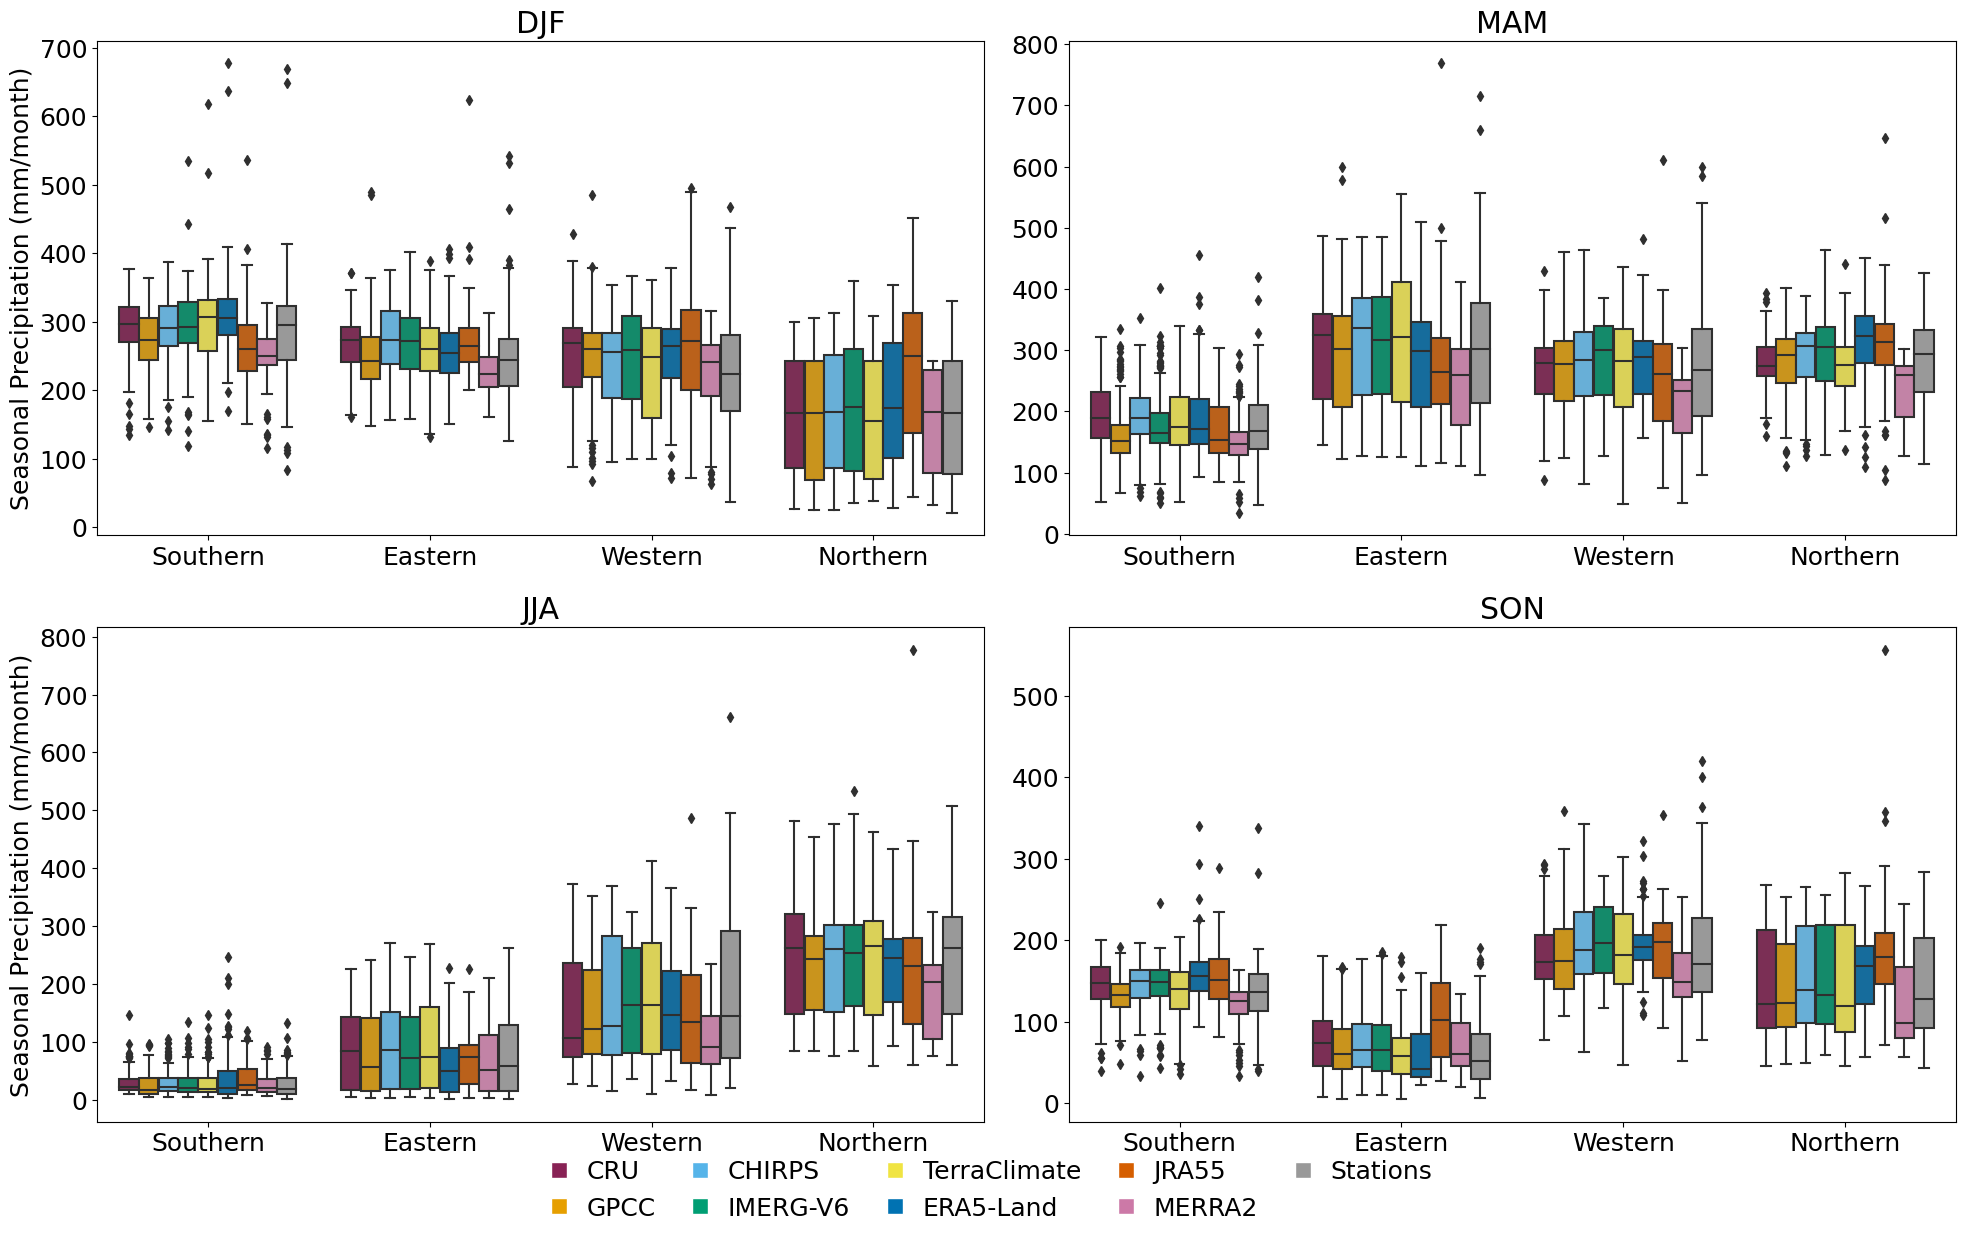

In [30]:
#plot box plot for each season
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))
axes = axes.flatten()
for i, season in enumerate(seasons):
    ax = axes[i]
    sns.boxplot(x="Region", y="pr", hue="Dataset", data=df[df['season']==season], ax=ax, hue_order=hue_order, palette=wong)
    ax.set_title(season)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend_.remove()
    # set label only in firstcolumn of plot
    if i%2==0:
        ax.set_ylabel('Seasonal Precipitation (mm/month)')
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)

plt.tight_layout()